In [1]:
#Parametric Method  ( Normal Distribution)

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'SCHD']

adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Adj Close']

log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
log_returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,SPY,BND,GLD,SCHD
Date,,,,
2011-10-21,0.018809,-0.001563,0.011031,0.019426
2011-10-24,0.012186,0.000722,0.009359,0.005482
2011-10-25,-0.019635,0.005157,0.027986,-0.016536
2011-10-26,0.010107,-0.002516,0.010871,0.010269
2011-10-27,0.034242,-0.005170,0.012762,0.022534
...,...,...,...,...
2024-02-12,-0.000439,0.000276,-0.002615,0.006102
2024-02-13,-0.013869,-0.008741,-0.013885,-0.015391
2024-02-14,0.009047,0.003755,-0.000596,0.003935


In [2]:
portfolio_value = 100
weights = np.array([1/len(tickers)] * len(tickers))
weights

array([0.25, 0.25, 0.25, 0.25])

In [3]:
historical_returns = (log_returns * weights).sum(axis=1)
historical_returns

Date
2011-10-21    0.011926
2011-10-24    0.006937
2011-10-25   -0.000757
2011-10-26    0.007183
2011-10-27    0.016092
                ...   
2024-02-12    0.000831
2024-02-13   -0.012971
2024-02-14    0.004035
2024-02-15    0.006887
2024-02-16   -0.001974
Length: 3100, dtype: float64

In [4]:
days = 5
historical_x_day_returns = historical_returns.rolling(window=days).sum().dropna()
historical_x_day_returns

Date
2011-10-27    0.041381
2011-10-28    0.030211
2011-10-31    0.009948
2011-11-01   -0.000208
2011-11-02    0.002291
                ...   
2024-02-12    0.006389
2024-02-13   -0.010989
2024-02-14   -0.008873
2024-02-15   -0.001866
2024-02-16   -0.003193
Length: 3096, dtype: float64

In [5]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,SPY,BND,GLD,SCHD
SPY,0.028594,0.000512,0.001575,0.024702
BND,0.000512,0.002460,0.002410,0.000300
GLD,0.001575,0.002410,0.022786,0.001210
SCHD,0.024702,0.000300,0.001210,0.024909


In [6]:
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
portfolio_std_dev

0.09359777296674823

In [7]:
from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)
VaRs

[-1.8305770807756871, -2.309557885472455, -3.20804621665072]

In [8]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.3f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $    -1.831
    95%:          $    -2.310
    99%:          $    -3.208


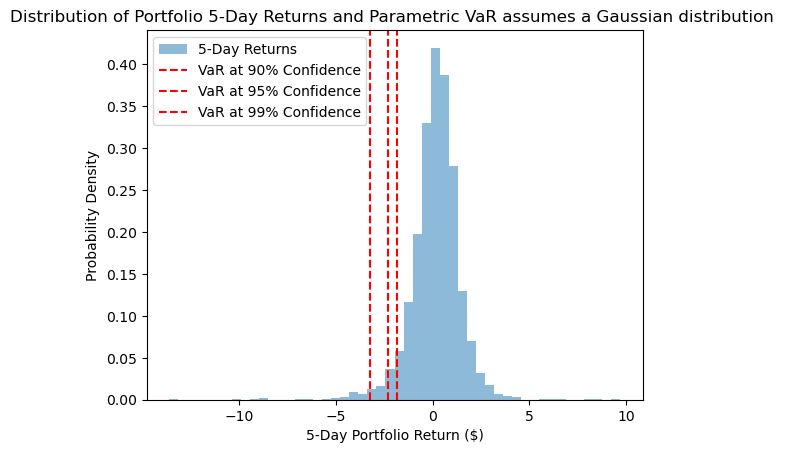

In [9]:
# Plot the histogram
plt.hist(historical_x_day_returns * portfolio_value, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Probability Density')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR assumes a Gaussian distribution ')
plt.legend()